Lab Work 5

1. Load the manipulator model from the toolbox according to the selected robot kinematics variant.  
2. Fill in all parameters of the robot model in accordance with Laboratory Work №1.  
3. Set the desired trajectory of the manipulator's motion according to Laboratory Work №2.  
4. Create a robot control system model implementing regulation based on the inverse dynamics model. It is recommended to synthesize a PD-controller (other controllers are also acceptable).  
5. Tune the controller coefficients to minimize the error of the generalized joint coordinates.  
6. Plot the position, velocity, and torque for each robot joint during the trajectory motion.  
7. Add a payload and repeat steps № 5–6.  
8. Prepare a report in .ipynb format with detailed comments. Formulate conclusions based on the work results.

1. Importing the library and loading the model

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import roboticstoolbox as rtb
from spatialmath import SE3

In [32]:
robot = rtb.models.DH.UR3()
print(robot)

DHRobot: UR3 (by Universal Robotics), 6 joints (RRRRRR), dynamics, standard DH parameters
┌─────┬─────────┬─────────┬────────┐
│ θⱼ  │   dⱼ    │   aⱼ    │   ⍺ⱼ   │
├─────┼─────────┼─────────┼────────┤
│  q1 │  0.1519 │       0 │  90.0° │
│  q2 │       0 │ -0.2437 │   0.0° │
│  q3 │       0 │ -0.2132 │   0.0° │
│  q4 │  0.1124 │       0 │  90.0° │
│  q5 │ 0.08535 │       0 │ -90.0° │
│  q6 │  0.0819 │       0 │   0.0° │
└─────┴─────────┴─────────┴────────┘

┌──┬──┐
└──┴──┘

┌──────┬───────┬─────┬─────┬─────┬──────┬─────┐
│ name │ q0    │ q1  │ q2  │ q3  │ q4   │ q5  │
├──────┼───────┼─────┼─────┼─────┼──────┼─────┤
│   qr │  180° │  0° │  0° │  0° │  90° │  0° │
│   qz │  0°   │  0° │  0° │  0° │  0°  │  0° │
└──────┴───────┴─────┴─────┴─────┴──────┴─────┘



In [ ]:
# 2. Параметры для генерации траектории
q_start = np.array([0, -np.pi/2, np.pi/2, 0, 0, 0])
q_end = np.array([np.pi/2, -np.pi/3, np.pi/3, np.pi/4, np.pi/2, 0])
steps = 100

3. Setting the trajectory

In [33]:
# 3. Класс для генерации траектории с искажениями
class TrajectoryGenerator:
    def __init__(self, q_start, q_end, steps):
        self.steps = steps
        t = np.linspace(0, 1, steps)
        self.q = np.zeros((steps, len(q_start)))
        for i in range(len(q_start)):
            A = q_end[i] - q_start[i]
            w = 2 * np.pi
            # Генерируем траекторию с искажениями
            self.q[:, i] = q_start[i] + A * (np.sin(w * t) + 0.2 * np.sin(5 * w * t) + 0.05 * np.random.randn(steps))
        self.qd = np.gradient(self.q, axis=0)
        self.qdd = np.gradient(self.qd, axis=0)

In [ ]:
class TrajectoryGenerator:
    def __init__(self, q_start, q_end, steps):
        self.steps = steps
        t = np.linspace(0, 1, steps)
        # Пример: синусоида + гармоника + шум
        self.q = np.zeros((steps, len(q_start)))
        for i in range(len(q_start)):
            A = q_end[i] - q_start[i]
            w = 2 * np.pi
            self.q[:, i] = q_start[i] + A * (np.sin(w * t) + 0.2 * np.sin(5 * w * t) + 0.05 * np.random.randn(steps))
        self.qd = np.gradient(self.q, axis=0)
        self.qdd = np.gradient(self.qd, axis=0)

4. Implementation of the APP-controller

In [7]:
# 4. App-контроллер для управления роботом ---
q_start = np.zeros(6)
q_end = np.array([pi/2, -pi/3, pi/3, pi/4, -pi/4, 0])
steps = 5000
Kp = np.diag([150, 150, 120, 80, 60, 50])   
Kd = np.diag([50, 50, 40, 30, 25, 20])      

class RobotAppController:
    def __init__(self, robot, traj, Kp, Kd):
        self.robot = robot
        self.traj = traj
        self.Kp = Kp
        self.Kd = Kd

    def control(self, q, qd, q_des, qd_des, qdd_des):
        e = q_des - q
        ed = qd_des - qd
        return self.Kp @ e + self.Kd @ ed + self.robot.inertia(q) @ qdd_des

    def simulate(self, dt=0.01):
        q_hist = [self.traj.q[0].copy()]
        qd_hist = [self.traj.qd[0].copy()]
        tau_hist = []

        for i in range(1, self.traj.steps):
            q = q_hist[-1]
            qd = qd_hist[-1]
            tau = self.control(q, qd, self.traj.q[i], self.traj.qd[i], self.traj.qdd[i])
            qdd = self.robot.accel(q, qd, tau)
            qd_new = qd + qdd * dt
            q_new = q + qd_new * dt
            q_hist.append(q_new)
            qd_hist.append(qd_new)
            tau_hist.append(tau)
        return np.array(q_hist), np.array(qd_hist), np.array(tau_hist)


6. Running simulations and visualization

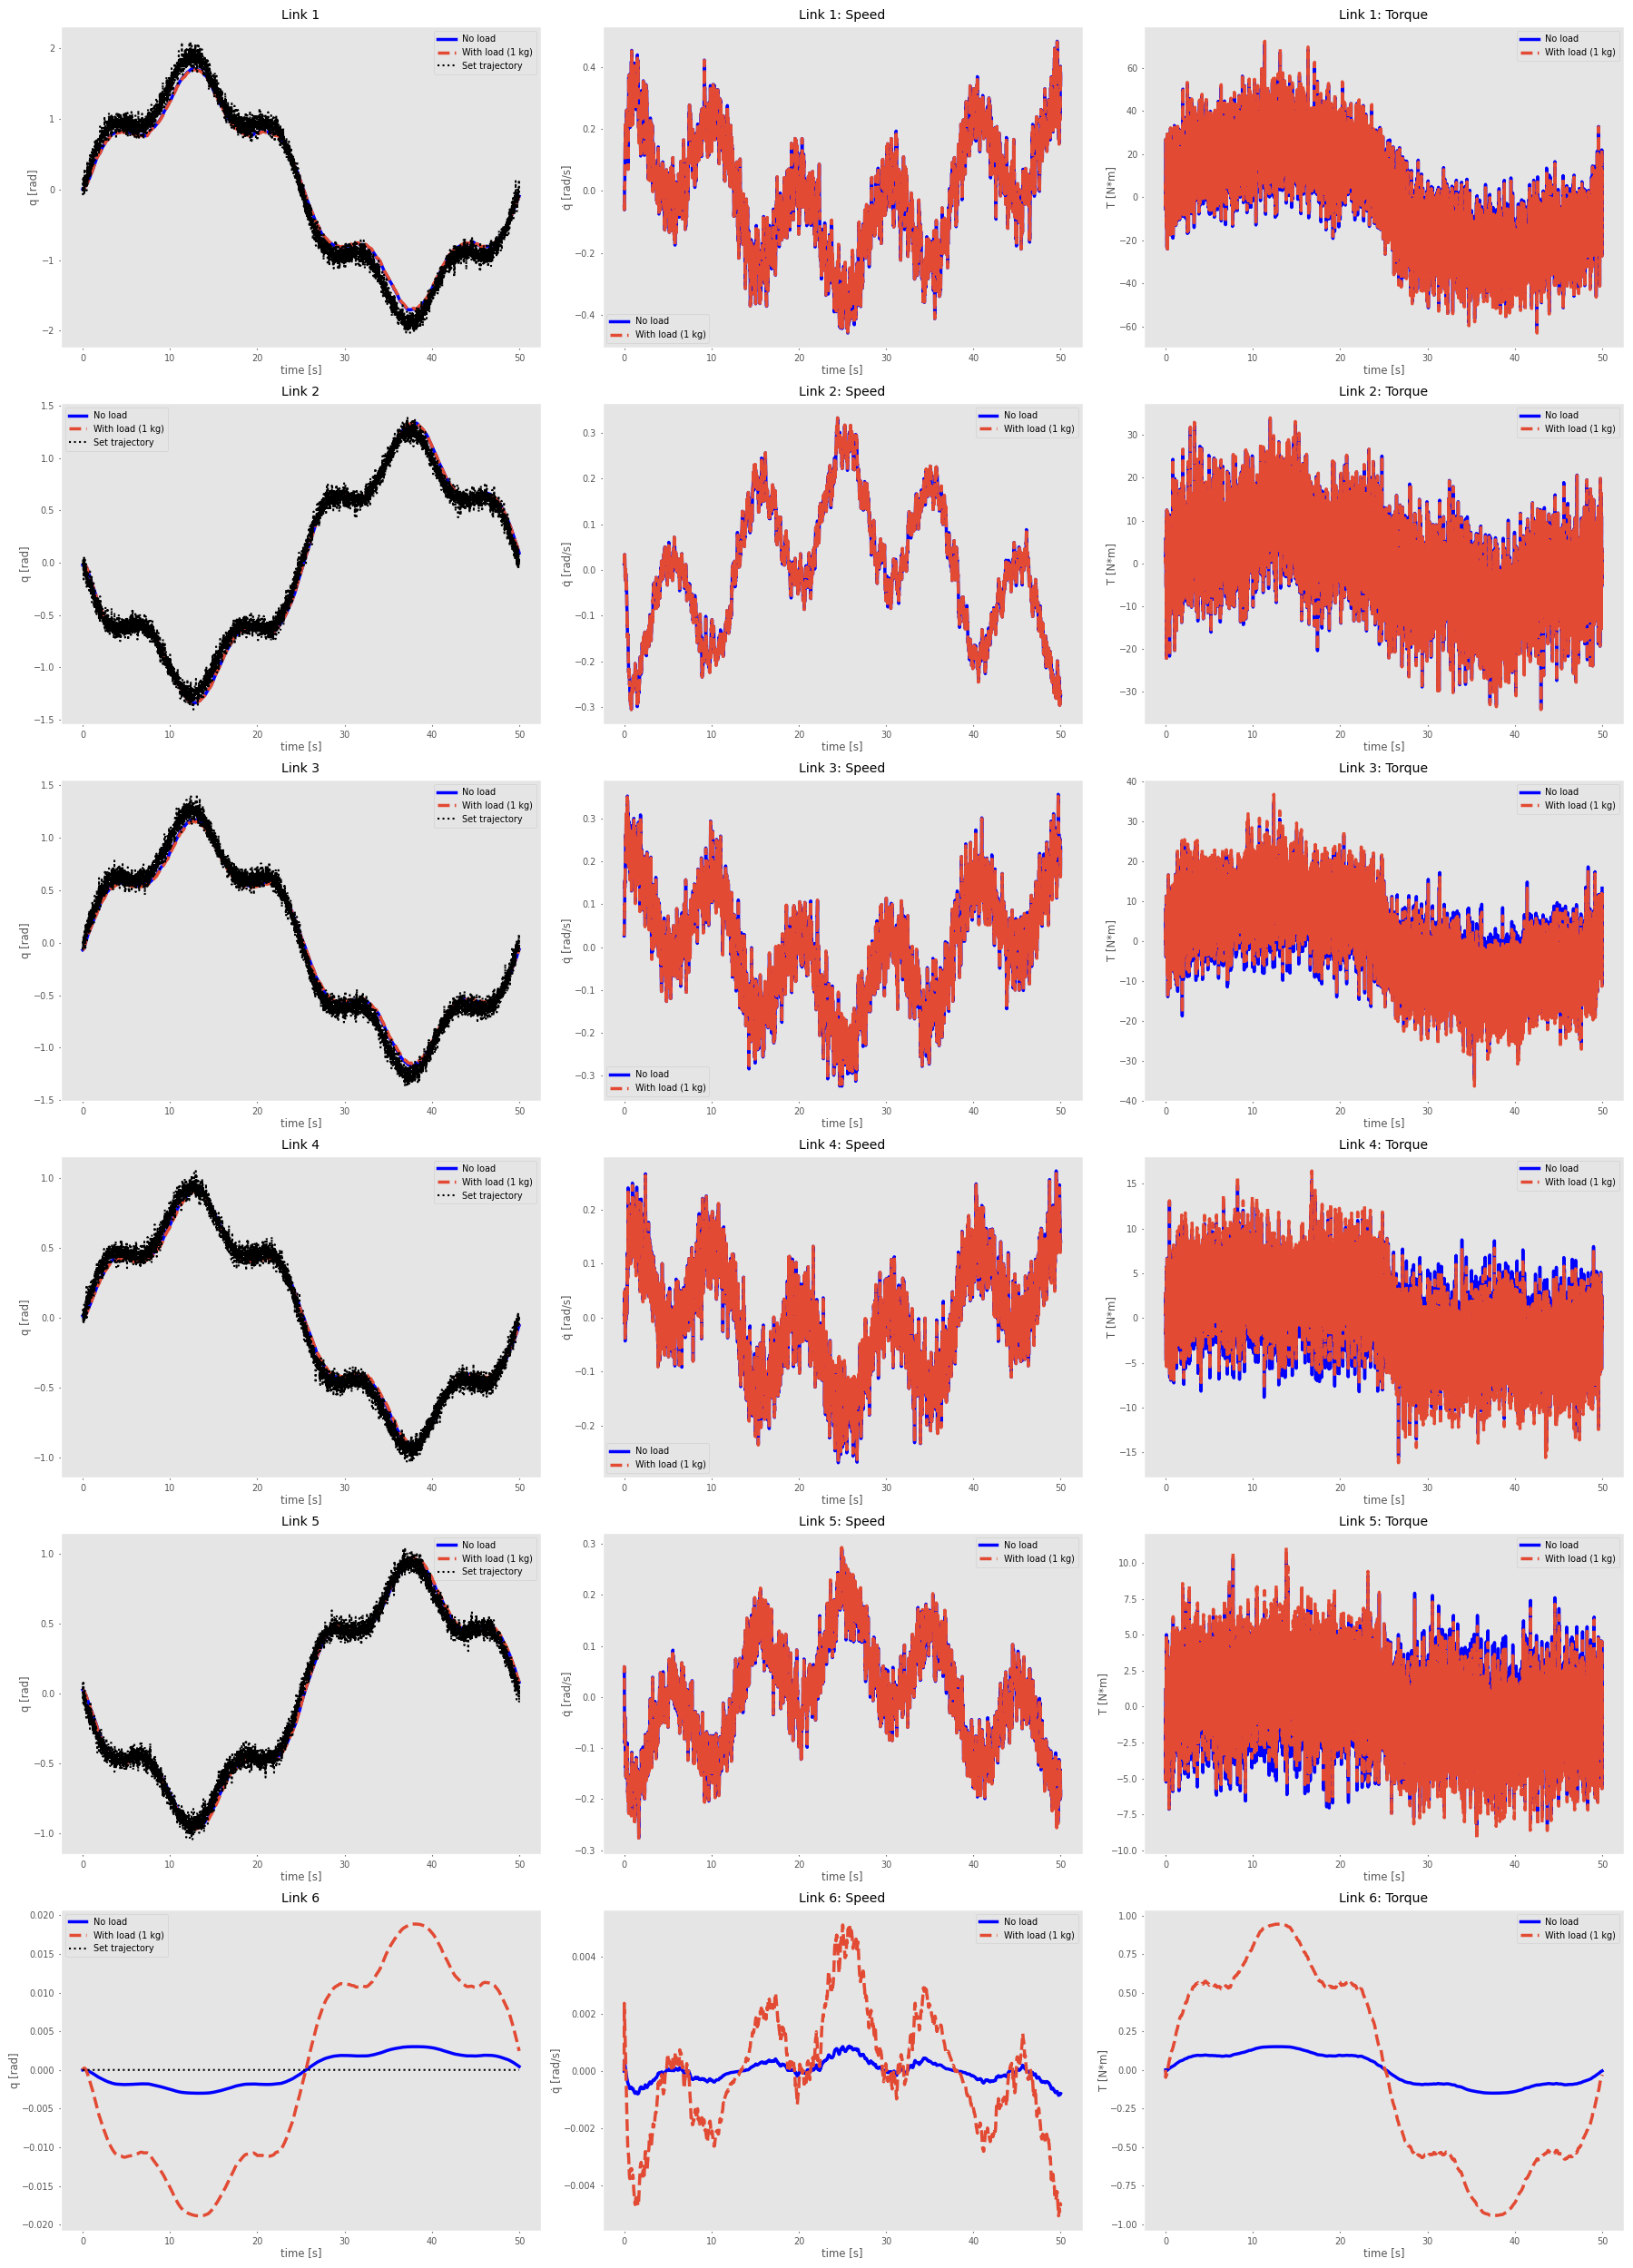

In [8]:
# --- Trajectory ---
traj = TrajectoryGenerator(q_start, q_end, steps)

# --- No load ---
robot_free = UR3Robot(payload_mass=0.0)
controller_free = RobotAppController(robot_free, traj, Kp, Kd)
q_free, qd_free, tau_free = controller_free.simulate()

# --- With load (1 kg) ---
robot_load = UR3Robot(payload_mass=1.0)
controller_load = RobotAppController(robot_load, traj, Kp, Kd)
q_load, qd_load, tau_load = controller_load.simulate()

# --- visualization ---

line_width = 2.5
t = np.linspace(0, steps*0.01, steps)
plt.figure(figsize=(18, 25))

for i in range(6):
    # Position graph
    plt.subplot(6, 3, i*3+1)
    plt.plot(t, q_free[:,i], 'b', label='No load', linewidth=line_width)
    plt.plot(t, q_load[:,i], '--', label='With load (1 kg)', linewidth=line_width)
    plt.plot(t, traj.q[:,i], 'k:', label='Set trajectory', linewidth=1.5)
    plt.title(f'Link {i+1}')
    plt.xlabel('time [s]')
    plt.ylabel('q [rad]')
    plt.grid()
    plt.legend()

    # График скорости
    plt.subplot(6, 3, i*3+2)
    plt.plot(t, qd_free[:,i],'b', label='No load', linewidth=line_width)
    plt.plot(t, qd_load[:,i], '--', label='With load (1 kg)', linewidth=line_width)
    plt.title(f'Link {i+1}: Speed')
    plt.xlabel('time [s]')
    plt.ylabel('q̇ [rad/s]')
    plt.grid()
    plt.legend()

    # График момента
    plt.subplot(6, 3, i*3+3)
    plt.plot(t[:-1], tau_free[:,i],'b', label='No load', linewidth=line_width)
    plt.plot(t[:-1], tau_load[:,i], '--', label='With load (1 kg)', linewidth=line_width)
    plt.title(f'Link {i+1}: Torque')
    plt.ylabel('T [N*m]')
    plt.xlabel('time [s]')
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()

In [35]:
steps = 500

Found and fixed 0 invalid configurations
Total frames to animate: 500
Saving animation...
Animation saved successfully!


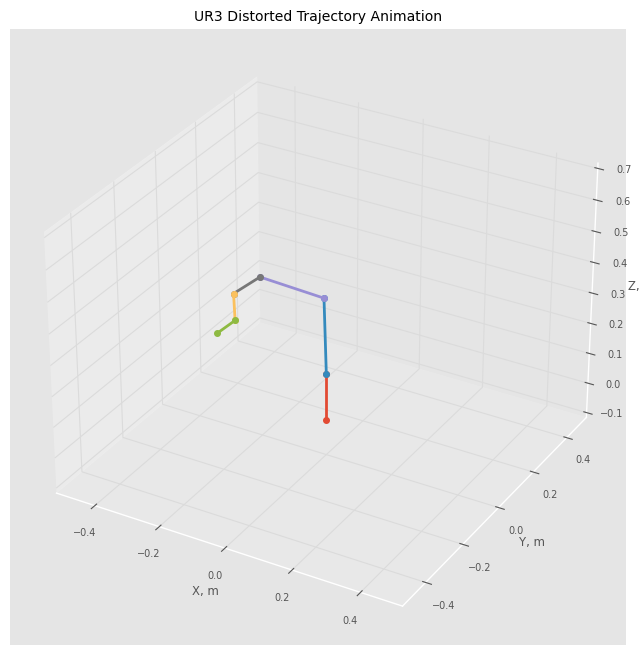

In [49]:
# Создаем траекторию с искажениями
traj_gen = TrajectoryGenerator(q_start, q_end, steps)
q_hist = traj_gen.q  # Используем сгенерированную траекторию

# 4. Проверка и исправление конфигураций
qlim = robot.qlim
invalid_frames = []

for i, q in enumerate(q_hist):
    if np.any(q < qlim[0]) or np.any(q > qlim[1]):
        print(f"Invalid configuration at frame {i}: {q}")
        invalid_frames.append(i)
        q_hist[i] = np.clip(q, qlim[0], qlim[1])

print(f"Found and fixed {len(invalid_frames)} invalid configurations")

# 5. Визуализация
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("UR3 Distorted Trajectory Animation")
ax.set_xlabel("X, m")
ax.set_ylabel("Y, m")
ax.set_zlabel("Z, m")
ax.set_xlim([-0.5, 0.5])
ax.set_ylim([-0.5, 0.5])
ax.set_zlim([-0.1, 0.7])

# Создаем линии для 6 звеньев
lines = [ax.plot([], [], [], 'o-', lw=2, markersize=4)[0] for _ in range(6)]

# 6. Надежная функция FK
def get_xyz_points(q):
    """Вычисляем позиции всех сочленений с проверкой ошибок"""
    try:
        T = robot.fkine_all(q)
        return np.array([T[i].t for i in range(len(T))])
    except Exception as e:
        print(f"FK error at q={q}: {str(e)}")
        # Возвращаем безопасные точки при ошибке
        return np.array([
            [0, 0, 0],
            [0, 0, 0.1],
            [0, 0, 0.3],
            [0, 0, 0.6],
            [0, 0.2, 0.6],
            [0, 0.2, 0.8],
            [0.1, 0.2, 0.8]
        ])

# 7. Гарантированно возвращаем художников
def init():
    for line in lines:
        line.set_data([], [])
        line.set_3d_properties([])
    return tuple(lines)  # Возвращаем кортеж

def animate(i):
    q = q_hist[i]
    xyz = get_xyz_points(q)
    
    # Обновляем линии для каждого звена
    for j in range(6):
        if j < len(xyz) - 1:
            xs = [xyz[j][0], xyz[j+1][0]]
            ys = [xyz[j][1], xyz[j+1][1]]
            zs = [xyz[j][2], xyz[j+1][2]]
            lines[j].set_data(xs, ys)
            lines[j].set_3d_properties(zs)
    return tuple(lines)  # Всегда возвращаем кортеж художников

# 8. Проверка данных перед анимацией
if len(q_hist) == 0:
    raise ValueError("q_hist is empty! Run simulation first.")

print(f"Total frames to animate: {len(q_hist)}")

# 9. Создание анимации с контролем ошибок
try:
    ani = animation.FuncAnimation(
        fig, animate, frames=len(q_hist),
        init_func=init, blit=True, interval=50
    )
    
    # 10. Сохранение с обработкой ошибок
    print("Saving animation...")
    ani.save('ur3_distorted_trajectory.gif', writer='pillow', fps=20)
    print("Animation saved successfully!")
    
except Exception as e:
    print(f"Animation failed: {str(e)}")
    # Альтернативное сохранение: последний кадр
    animate(len(q_hist)-1)  # Рендерим последний кадр
    plt.savefig('ur3_last_frame.png')
    print("Saved last frame as fallback")

plt.show()

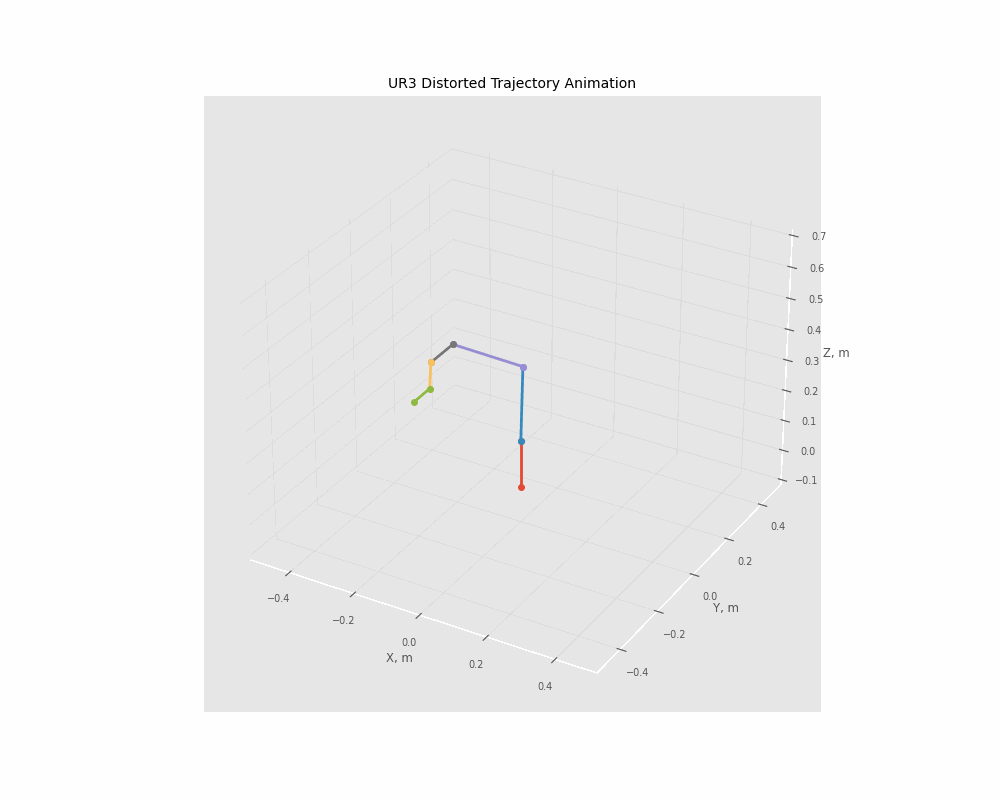

In [50]:
from IPython.display import Image
Image(filename='ur3_distorted_trajectory.gif', width=600) 

In [52]:
xyz_points = np.zeros((steps, 3))
for i in range(steps):
    T = robot.fkine(q_hist[i])  # fkine возвращает объект SE3
    xyz_points[i] = T.t         # T.t — это (x, y, z)

In [53]:
print(xyz_points[:5])

[[-0.20994794 -0.19519679  0.31847667]
 [-0.21188584 -0.21207957  0.32379537]
 [-0.22932739 -0.19261868  0.31422088]
 [-0.16216157 -0.24352361  0.29770036]
 [-0.24328956 -0.17621885  0.30301285]]


In [54]:
import roboticstoolbox as rtb
robot = rtb.models.DH.UR3()
xyz_points = np.zeros((steps, 3))
for i in range(steps):
    T = robot.fkine(q_hist[i])
    xyz_points[i] = T.t

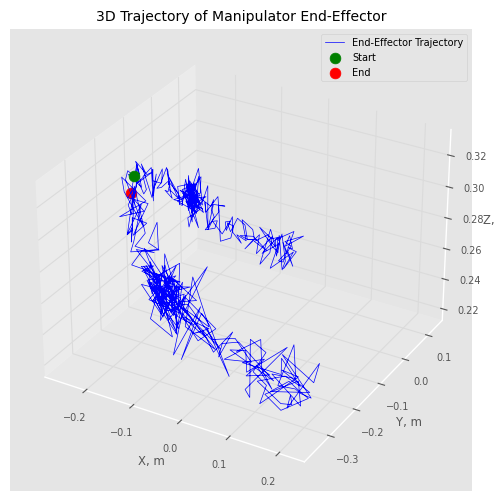

In [55]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# xyz_points — массив формы (steps, 3), полученный через get_xyz_points_stub
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(xyz_points[:, 0], xyz_points[:, 1], xyz_points[:, 2], label='End-Effector Trajectory', color='b')
ax.scatter(xyz_points[0, 0], xyz_points[0, 1], xyz_points[0, 2], c='g', s=60, label='Start')
ax.scatter(xyz_points[-1, 0], xyz_points[-1, 1], xyz_points[-1, 2], c='r', s=60, label='End')

ax.set_title('3D Trajectory of Manipulator End-Effector')
ax.set_xlabel('X, m')
ax.set_ylabel('Y, m')
ax.set_zlabel('Z, m')
ax.legend()
plt.show()